In [33]:
import tensorflow as tf
import time
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
from tensorflow.contrib.framework import assign_from_checkpoint_fn
from lib import inception_resnet_v2
import matplotlib.pyplot as plt
import os
import shutil
import math
import random
import csv

from pre_process import read_image
from pre_process import config_log

# 构造验证数据集合

In [ ]:
def build_valiation_data(src_dir, target_dir, validation_ratio):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    files = os.listdir(src_dir)
    total_size = len(files)
    validation_size = int(total_size * validation_ratio)
    
    random.shuffle(files)
    for i in range(validation_size):
        f = files[i]
        shutil.move(os.path.join(src_dir, f), os.path.join(target_dir, f))
    print("total size: {}, validation size: {}".format(total_size, validation_size))
    
# build_valiation_data("input/train", "input/validation", 0.2)

# 测试双队列读取训练集、验证集

step=000 cost=4.44 train_size=2000 validation_size=1000
step=001 cost=4.32 train_size=2000 validation_size=1000
step=002 cost=2.77 train_size=2000 validation_size=1000
step=003 cost=2.90 train_size=2000 validation_size=1000
step=004 cost=2.70 train_size=2000 validation_size=1000
step=005 cost=2.74 train_size=2000 validation_size=1000
step=006 cost=2.73 train_size=2000 validation_size=1000
step=007 cost=2.82 train_size=2000 validation_size=1000
step=008 cost=2.92 train_size=2000 validation_size=1000
step=009 cost=4.57 train_size=1988 validation_size=1000
Done training -- epoch limit reached


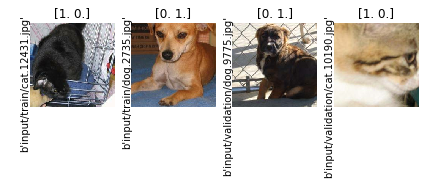

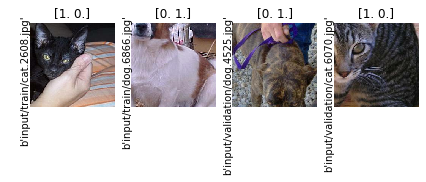

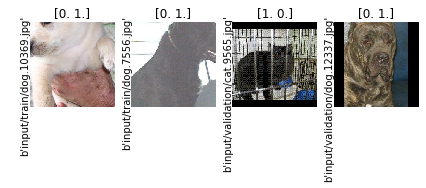

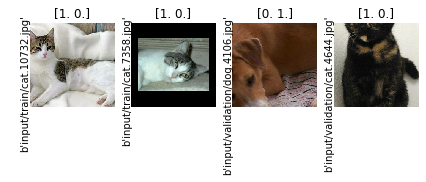

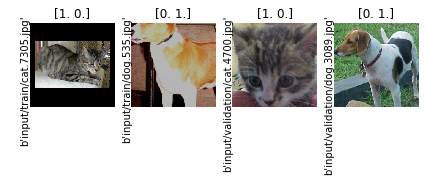

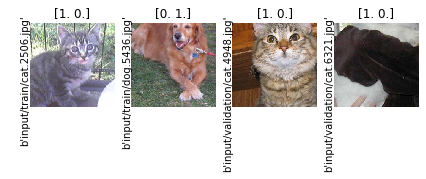

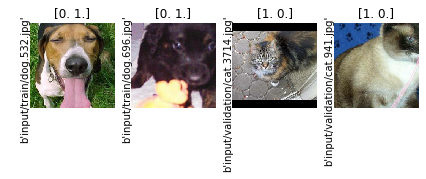

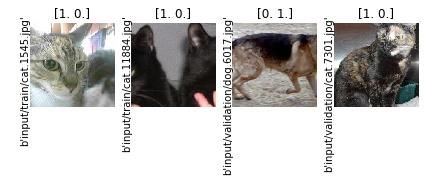

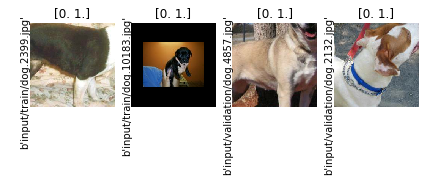

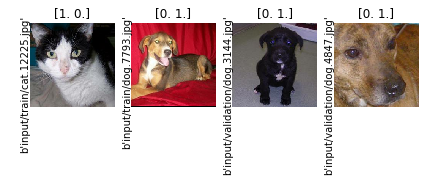

In [34]:
image_h, image_w = 224, 224
BATCH_THREADS = 10
BATCH_CAPACITY = 10000

train_image_path = "input/train/*.jpg"
validation_image_path = "input/validation/*.jpg"

tf.reset_default_graph()

with tf.Session() as sess:
    image_batch_train, label_batch_train, name_batch_train = read_image(
        train_image_path, image_h, image_w, epochs=1, batch_size=2000, batch_threads=BATCH_THREADS, 
        batch_capacity=1000*2)
    
    image_batch_val, label_batch_val, name_batch_val = read_image(
        validation_image_path, image_h, image_w, epochs=None, batch_size=1000, batch_threads=BATCH_THREADS, 
        batch_capacity=1000*2)
    
    sess.run((tf.global_variables_initializer(), tf.local_variables_initializer()))
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    step = 0
    try:
        while not coord.should_stop():
            start_time = time.time()
            image_batch_train_data, label_batch_train_data, name_batch_train_data, \
            image_batch_val_data, label_batch_val_data, name_batch_val_data = sess.run(
                [image_batch_train, label_batch_train, name_batch_train, 
                 image_batch_val, label_batch_val, name_batch_val])
            end_time = time.time()   
            print("step={:0>3d} cost={:.2f} train_size={} validation_size={}".format(
                step, end_time - start_time, image_batch_train_data.shape[0], image_batch_val_data.shape[0]))
#             print(image_batch_train_data.shape, label_batch_train_data.shape)
#             print(image_batch_val_data.shape, label_batch_val_data.shape)
            
            plt.figure(figsize=(8,6))
            N = 4
            for i in range(0,int(N/2)):
                ax = plt.subplot(1,N,i+1)
                ax.tick_params(axis='both', which='both',length=0)
                ax.set_title("{}".format(label_batch_train_data[i]))
                ax.text(-25, 0, "{}".format(name_batch_train_data[i]), rotation="vertical")
                ax.axis('off')
                plt.imshow(image_batch_train_data[i])
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            
            for i in range(0, int(N/2)):
                ax = plt.subplot(1,N, i + int(N/2)+1)
                ax.tick_params(axis='both', which='both',length=0)
                ax.set_title("{}".format(label_batch_val_data[i]))
                ax.text(-25, 0, "{}".format(name_batch_val_data[i]), rotation="vertical")
                ax.axis('off')
                plt.imshow(image_batch_val_data[i])
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

            step += 1

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()

    coord.join(threads)
    

# 日志

In [3]:
import logging

def config_log(file_name):
    logging.basicConfig(level=logging.DEBUG,
                    format='%(levelname)s %(asctime)s %(filename)s[line:%(lineno)d] %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename=file_name,
                    filemode='w')

# train

In [27]:
def accuracy_fn(predictions, labels, name='accuracy'):
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32), name=name)

def filter_train_variables_by_name(names):
    variables = list()
    for v in tf.trainable_variables():
        for name in names:
            if v.name.find(name) == 0:
                variables.append(v)
    return variables

# inception_resnet_v2 训练

In [62]:
def train_inception_resnet_v2(train_log_dir="logs_inception_resnet_v2", epochs=10):
    PRE_TRAINED_MODEL_DIR = 'pre_train_model/inception_resnet_v2_2016_08_30.ckpt'
    train_image_path = "input/train/*.jpg"
    validation_image_path = "input/validation/*.jpg"
    
    TRAIN_BATCH_SIZE = 32
    VALIDATION_BATCH_SIZE = 32
    BATCH_THREADS = 12
    BATCH_CAPACITY = 1000
    
    log_every_n_steps = 100
    
    EPOCHS = epochs
    TRAIN_IMAGE_NUMS = 20000
    TOTAL_STEP = int(TRAIN_IMAGE_NUMS / TRAIN_BATCH_SIZE * EPOCHS)
    LEARNING_RATE = 0.001
    
    config = tf.ConfigProto()  
    config.gpu_options.allow_growth=True  
    
    image_h, image_w = 299, 299

    with tf.Graph().as_default():

        image_train, label_train, name_train = read_image(
            train_image_path, image_h, image_w, epochs=None, batch_size=TRAIN_BATCH_SIZE, batch_threads=BATCH_THREADS, 
            batch_capacity=TRAIN_BATCH_SIZE*2)
    
        image_val, label_val, name_val = read_image(
            validation_image_path, image_h, image_w, epochs=None, batch_size=VALIDATION_BATCH_SIZE, batch_threads=BATCH_THREADS, 
            batch_capacity=VALIDATION_BATCH_SIZE*2)
    
        with tf.variable_scope('InceptionResnetV2') as scope:
            with slim.arg_scope(inception_resnet_v2.inception_resnet_v2_arg_scope()):
                predictions, end_points = inception_resnet_v2.inception_resnet_v2(image_train, num_classes=2, scope=scope)
                scope.reuse_variables()
                predictions_val, end_points_val = inception_resnet_v2.inception_resnet_v2(image_val, num_classes=2, scope=scope, is_training=False)
 
            
        excludes = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude=excludes)
        init_fn = assign_from_checkpoint_fn(PRE_TRAINED_MODEL_DIR, variables_to_restore)        

        # Specify the loss function:
        loss = tf.losses.softmax_cross_entropy(label_train, predictions)
        total_loss = slim.losses.get_total_loss()
        
        loss_val = tf.losses.softmax_cross_entropy(label_val, predictions_val)
        
        accuracy = accuracy_fn(predictions, label_train)
        accuracy_val = accuracy_fn(predictions_val, label_val, "accuracy_val")

        tf.summary.scalar('train/loss', loss)
        tf.summary.scalar('train/accuracy', accuracy)
        tf.summary.image('train/inputs', tf.reshape(image_train, [-1, image_h, image_w, 3]), 5)
        
        tf.summary.scalar('validation/loss', loss_val)
        tf.summary.scalar('validation/accuracy', accuracy_val)
        tf.summary.image('validation/inputs', tf.reshape(image_val, [-1, image_h, image_w, 3]), 5)
        
        global_step = slim.get_or_create_global_step()
#         learning_rate = tf.train.exponential_decay(0.1, global_step, 500, 0.96, staircase=True)
        learning_rate = LEARNING_RATE

        # Specify the optimization scheme:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

        # create_train_op that ensures that when we evaluate it to get the loss,
        # the update_ops are done and the gradient updates are computed.
        variables_to_train = filter_train_variables_by_name(excludes)
        train_tensor = slim.learning.create_train_op(total_loss, optimizer, global_step=global_step, 
                variables_to_train=variables_to_train)
        # Actually runs training.

        def train_step(sess, train_op, global_step, train_step_kwargs): 
            global_step_value, accuracy_value, loss_value, accuracy_validation_value, loss_val_value = \
                sess.run([global_step, accuracy, loss, accuracy_val, loss_val])
            if global_step_value % log_every_n_steps == 0 or global_step_value >= TOTAL_STEP:
                tf.logging.info("global step {}: accuracy = {} loss = {} accuracy_val = {} loss_val = {}".format(
                    global_step_value, accuracy_value, loss_value, accuracy_validation_value, loss_val_value))

            return slim.learning.train_step(sess, train_op, global_step, train_step_kwargs)

        slim.learning.train(train_tensor, train_log_dir, 
                            init_fn=init_fn, train_step_fn=train_step, global_step=global_step, 
                            log_every_n_steps=log_every_n_steps, save_summaries_secs=60, 
                            save_interval_secs=600, number_of_steps=TOTAL_STEP, session_config=config)

In [63]:
train_inception_resnet_v2(train_log_dir="logs/inception_resnet_v2", epochs=5)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Restoring parameters from pre_train_model/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path logs/inception_resnet_v2/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global step 0: accuracy = 0.5625 loss = 0.730705738067627 accuracy_val = 0.8125 loss_val = 0.543617308139801
INFO:tensorflow:Recording summary at step 77.
INFO:tensorflow:global step 100: loss = 0.6090 (0.288 sec/step)
INFO:tensorflow:global step 100: accuracy = 0.9375 loss = 0.14444446563720703 accuracy_val = 0.90625 loss_val = 0.1134117990732193
INFO:tensorflow:Recording summary at step 157.
INFO:tensorflow:global step 200: loss = 0.5970 (0.302 sec/step)
INFO:tensorflow:global step 200: accu

INFO:tensorflow:global step 2700: loss = 0.5338 (0.286 sec/step)
INFO:tensorflow:global step 2700: accuracy = 1.0 loss = 0.039763424545526505 accuracy_val = 1.0 loss_val = 0.004832398146390915
INFO:tensorflow:Recording summary at step 2735.
INFO:tensorflow:global step 2800: loss = 0.5406 (0.279 sec/step)
INFO:tensorflow:global step 2800: accuracy = 0.9375 loss = 0.23333320021629333 accuracy_val = 1.0 loss_val = 0.023364173248410225
INFO:tensorflow:Recording summary at step 2813.
INFO:tensorflow:Recording summary at step 2891.
INFO:tensorflow:global step 2900: loss = 0.5412 (0.276 sec/step)
INFO:tensorflow:global step 2900: accuracy = 1.0 loss = 0.013834911398589611 accuracy_val = 0.96875 loss_val = 0.03233334422111511
INFO:tensorflow:Recording summary at step 2970.
INFO:tensorflow:global step 3000: loss = 0.5484 (0.278 sec/step)
INFO:tensorflow:global step 3000: accuracy = 0.96875 loss = 0.030359994620084763 accuracy_val = 1.0 loss_val = 0.00258036982268095
INFO:tensorflow:Recording su

# 预测

In [56]:
image_path = "input/test/*.jpg"

def predirect_test(image_path, model, checkpoint_file_or_dir, log_file, output_file = "output/predict_test.csv"):

    BATCH_SIZE = 32
    BATCH_THREADS = 10
    BATCH_CAPACITY = BATCH_THREADS*2
    
    step = 0
    test_image_num = 12500
    max_step = math.ceil(test_image_num/BATCH_SIZE)
    count = 0

    tf.reset_default_graph()
    config_log(log_file)

    with open(output_file, "w") as fp:
        writer = csv.writer(fp) 
        writer.writerow(["id","label"])
        with tf.Graph().as_default():
            with tf.Session() as sess:
                
                if model == "vgg_16":
                    image_h, image_w = 224, 224
                    model_fn = nets.vgg.vgg_16
                    inputs, files = read_test_image(image_path, image_h, image_w, epochs=1, batch_size=BATCH_SIZE, 
                                    batch_threads=BATCH_THREADS, batch_capacity=BATCH_CAPACITY)
                    predictions, _ = model_fn(inputs, num_classes=2, is_training=False)
                elif model == "inception_resnet_v2":
                    image_h, image_w = 299, 299                    
                    model_fn = inception_resnet_v2.inception_resnet_v2
                    inputs, files = read_test_image(image_path, image_h, image_w, epochs=1, batch_size=BATCH_SIZE, 
                                    batch_threads=BATCH_THREADS, batch_capacity=BATCH_CAPACITY)
                    with slim.arg_scope(inception_resnet_v2.inception_resnet_v2_arg_scope()):
                        predictions, _ = model_fn(inputs, num_classes=2, is_training=False)
                else:
                    raise ValueError("model {} not supported".format(model))   
                    
                variables_to_restore = slim.get_model_variables()
                sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

                restorer = tf.train.Saver(variables_to_restore)
                if os.path.isdir(checkpoint_file_or_dir):
                    ckpt = tf.train.latest_checkpoint(checkpoint_file_or_dir)
                elif os.path.isfile(checkpoint_file_or_dir):
                    ckpt = checkpoint_file_or_dir
                else:
                    raise ValueError("checkpoint not found from {}".format(checkpoint_file_or_dir))
                tf.logging.info("found ckpt : {}".format(ckpt))
                restorer.restore(sess, ckpt)


                coord = tf.train.Coordinator()
                threads = tf.train.start_queue_runners(sess=sess, coord=coord)
                try:
                    while not coord.should_stop():
                        if count >= test_image_num:
                            break
                        preds, img_ids = sess.run([tf.nn.softmax(predictions), files])
                        tf.logging.info("step = {}".format(step))
                        for i, pred in enumerate(preds):
                            writer.writerow([int(img_ids[i]), pred[1]])

                        count += len(img_ids)
                        step += 1
                except tf.errors.OutOfRangeError:
                    print('Done training -- epoch limit reached')
                finally:
                    coord.request_stop()

                coord.join(threads)

In [66]:
predirect_test("input/test/*.jpg", "inception_resnet_v2", "logs/inception_resnet_v2", "test_logs/201803181148.log")

INFO:tensorflow:found ckpt : logs/inception_resnet_v2/model.ckpt-3125
INFO:tensorflow:Restoring parameters from logs/inception_resnet_v2/model.ckpt-3125
INFO:tensorflow:step = 0
INFO:tensorflow:step = 1
INFO:tensorflow:step = 2
INFO:tensorflow:step = 3
INFO:tensorflow:step = 4
INFO:tensorflow:step = 5
INFO:tensorflow:step = 6
INFO:tensorflow:step = 7
INFO:tensorflow:step = 8
INFO:tensorflow:step = 9
INFO:tensorflow:step = 10
INFO:tensorflow:step = 11
INFO:tensorflow:step = 12
INFO:tensorflow:step = 13
INFO:tensorflow:step = 14
INFO:tensorflow:step = 15
INFO:tensorflow:step = 16
INFO:tensorflow:step = 17
INFO:tensorflow:step = 18
INFO:tensorflow:step = 19
INFO:tensorflow:step = 20
INFO:tensorflow:step = 21
INFO:tensorflow:step = 22
INFO:tensorflow:step = 23
INFO:tensorflow:step = 24
INFO:tensorflow:step = 25
INFO:tensorflow:step = 26
INFO:tensorflow:step = 27
INFO:tensorflow:step = 28
INFO:tensorflow:step = 29
INFO:tensorflow:step = 30
INFO:tensorflow:step = 31
INFO:tensorflow:step = 32

INFO:tensorflow:step = 302
INFO:tensorflow:step = 303
INFO:tensorflow:step = 304
INFO:tensorflow:step = 305
INFO:tensorflow:step = 306
INFO:tensorflow:step = 307
INFO:tensorflow:step = 308
INFO:tensorflow:step = 309
INFO:tensorflow:step = 310
INFO:tensorflow:step = 311
INFO:tensorflow:step = 312
INFO:tensorflow:step = 313
INFO:tensorflow:step = 314
INFO:tensorflow:step = 315
INFO:tensorflow:step = 316
INFO:tensorflow:step = 317
INFO:tensorflow:step = 318
INFO:tensorflow:step = 319
INFO:tensorflow:step = 320
INFO:tensorflow:step = 321
INFO:tensorflow:step = 322
INFO:tensorflow:step = 323
INFO:tensorflow:step = 324
INFO:tensorflow:step = 325
INFO:tensorflow:step = 326
INFO:tensorflow:step = 327
INFO:tensorflow:step = 328
INFO:tensorflow:step = 329
INFO:tensorflow:step = 330
INFO:tensorflow:step = 331
INFO:tensorflow:step = 332
INFO:tensorflow:step = 333
INFO:tensorflow:step = 334
INFO:tensorflow:step = 335
INFO:tensorflow:step = 336
INFO:tensorflow:step = 337
INFO:tensorflow:step = 338
I

# 结果可视化

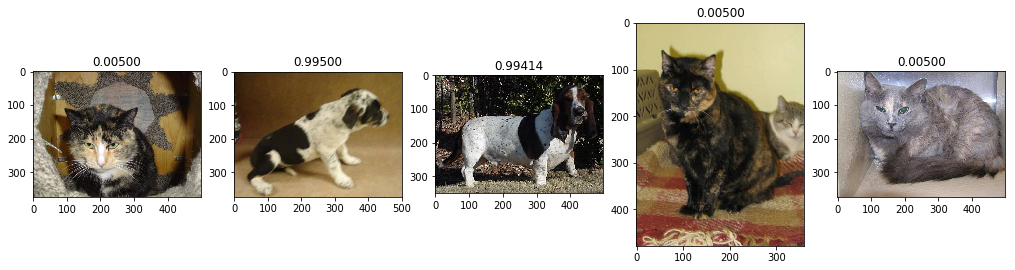

In [30]:
import pandas as pd
import matplotlib.image as mpimg

output = "output/predict_test_201803200838.csv"
test_dir = "input/test"

df = pd.read_csv(output)
samples = df.sample(5)
plt.figure(figsize=(20,6))
for i, sample in enumerate(samples.iterrows()):
    row = sample[1]
#     print(row["id"], row["label"])
    ax = plt.subplot(1, 5, i+1)
    ax.set_title("{:.5f}".format(row["label"]))
    img = mpimg.imread(test_dir + "/" + str(int(row["id"])) + ".jpg")
    plt.imshow(img)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)